# Build Simple Tool-Use AI Agents in LangGraph

Here we will extend the capability of the previously built Augmented LLM with feedback from the tool execution back to the LLM node to process it and generate human-like answers to user queries.

### Tool-based Agentic AI System

- Dynamic Decision-Making: LLM determines whether to directly respond or invoke a tool based on the query context.
- Seamless Tool Integration: External tools are integrated to handle specific tasks, such as real-time web queries or computations.
- Workflow Flexibility: Conditional routing ensures efficient task delegation:
  - Tool Required: Routes to tool execution.
  - No Tool Required: Ends the workflow with an LLM response.
- Feedback Loop: Incorporates a feedback loop to improve responses by combining LLM insights and tool outputs to further improve responses or call more tools if needed

![](https://i.imgur.com/DHxiOLl.png)


In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

## Enter Open AI API Key

In [8]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [9]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [10]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [11]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Augment the LLM with tools

Here we define our custom search tool and then bind it to the LLM to augment the LLM

In [12]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool

llm = ChatOpenAI(model="gpt-4o", temperature=0)

tavily_search = TavilySearchAPIWrapper()
@tool
def search_web(query: str, num_results=5):
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=num_results,
                                        search_depth='advanced',
                                        include_raw_content=True)
    return results

tools = [search_web]
llm_with_tools = llm.bind_tools(tools=tools)

In [13]:
llm_with_tools.invoke('what is the latest news on nvidia')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a08lTSpxSyzMDNBHjJ11PVNd', 'function': {'arguments': '{"query":"latest news on Nvidia","num_results":5}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 73, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f8f3a49a-2135-4cc8-8155-dd37969a0fa6-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'latest news on Nvidia', 'num_results': 5}, 'id': 'call_a08lTSpxSyzMDNBHjJ11PVNd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 73, 'output_tokens': 23, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_rea

## Create the Graph with the Tool-Use Agentic System

![](https://i.imgur.com/DHxiOLl.png)

In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Augmented LLM with Tools Node function
def tool_calling_llm(state: State) -> State:
    current_state = state["messages"]
    return {"messages": [llm_with_tools.invoke(current_state)]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")

# Conditional Edge
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from LLM is a tool call -> tools_condition routes to tools
    # If the latest message (result) from LLM is a not a tool call -> tools_condition routes to END
    tools_condition,
    ["tools", END]
)
builder.add_edge("tools", "tool_calling_llm") # this is the key feedback loop
builder.add_edge("tools", END)
agent = builder.compile()

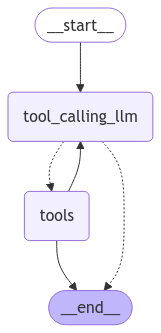

In [15]:
agent

In [16]:
user_input = "Explain AI in 2 bullets"
for event in agent.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain AI in 2 bullets
================================== Ai Message ==================================

- **Artificial Intelligence (AI)** refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions), and self-correction.

- **Applications of AI** include expert systems, natural language processing, speech recognition, and machine vision. AI technologies are used to automate tasks, enhance decision-making, and improve efficiency across various industries such as healthcare, finance, and transportation.


In [17]:
user_input = "What is the latest news on OpenAI product releases"
for event in agent.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is the latest news on OpenAI product releases
================================== Ai Message ==================================
Tool Calls:
  search_web (call_Es65OE0T81Hz9Vtnt5gDnx5O)
 Call ID: call_Es65OE0T81Hz9Vtnt5gDnx5O
  Args:
    query: OpenAI latest product releases
    num_results: 5
================================= Tool Message =================================
Name: search_web

{"query": "OpenAI latest product releases", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "OpenAI teases 12 days of mystery product launches starting tomorrow", "url": "https://arstechnica.com/ai/2024/12/openai-teases-12-days-of-mystery-product-launches-starting-tomorrow/", "content": "OpenAI teases 12 days of mystery product launches starting tomorrow - Ars Technica OpenAI's \"12 days of shipmas\" will reveal new AI releases and demos for two weeks. On Wednesday, OpenAI CEO Sam Al

In [18]:
event['messages'][-1]

AIMessage(content='OpenAI has recently announced a series of product releases as part of their "12 days of shipmas" event, which began on December 5, 2024. Here are some of the key highlights:\n\n1. **Sora**: OpenAI is launching its long-awaited text-to-video AI tool, Sora. This tool allows users to generate up to 20-second-long videos, animate still images, and remix videos. Initially, Sora was available only to selected users, but it is now being rolled out to certain OpenAI subscribers.\n\n2. **ChatGPT Pro**: OpenAI introduced a new subscription tier called ChatGPT Pro, priced at $200 per month. This plan offers unlimited access to OpenAI\'s most advanced models, including the o1 reasoning model and GPT-4o, along with features like Advanced Voice Mode.\n\n3. **o1 Reasoning Model**: The full version of OpenAI\'s o1 reasoning model has been released, replacing the previous o1-preview. This model is available to ChatGPT Plus and Team users, with Enterprise and Edu users gaining access 

In [19]:
from IPython.display import display, Markdown

display(Markdown(event['messages'][-1].content))

OpenAI has recently announced a series of product releases as part of their "12 days of shipmas" event, which began on December 5, 2024. Here are some of the key highlights:

1. **Sora**: OpenAI is launching its long-awaited text-to-video AI tool, Sora. This tool allows users to generate up to 20-second-long videos, animate still images, and remix videos. Initially, Sora was available only to selected users, but it is now being rolled out to certain OpenAI subscribers.

2. **ChatGPT Pro**: OpenAI introduced a new subscription tier called ChatGPT Pro, priced at $200 per month. This plan offers unlimited access to OpenAI's most advanced models, including the o1 reasoning model and GPT-4o, along with features like Advanced Voice Mode.

3. **o1 Reasoning Model**: The full version of OpenAI's o1 reasoning model has been released, replacing the previous o1-preview. This model is available to ChatGPT Plus and Team users, with Enterprise and Edu users gaining access soon.

4. **Canvas Feature**: OpenAI has made the Canvas feature available to all ChatGPT users on Web and Windows, with plans to expand to Mac and mobile platforms. This feature includes capabilities like Python code execution and shortcuts for easier content management.

5. **Reinforcement Fine-Tuning**: OpenAI is expanding its Reinforcement Fine-Tuning Research Program, allowing developers to create expert models fine-tuned for specific tasks. This feature is currently in the alpha phase with select participants.

These releases reflect OpenAI's commitment to advancing AI technology and making it accessible to a wide range of users. For more detailed information, you can check the [Ars Technica](https://arstechnica.com/ai/2024/12/openai-teases-12-days-of-mystery-product-launches-starting-tomorrow/) and [The Verge](https://www.theverge.com/24314146/openai-12-days-ship-mas-chatgpt-sora-o1-update) articles.